In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import math
import torch
import gpytorch
import sys
import re
import statistics
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data/DDG_Dataset.csv')
df = df[df['Temperature'] != "'-"]
ndatas = df.shape[0]
print(df.columns)
df

Index(['Rowid', 'ID', 'Protein Name', 'Mutation', 'Chain', 'PDB',
       'Temperature', 'pH', 'ΔΔG', 'Reference', 'A', 'R', 'N', 'D', 'C', 'Q',
       'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V',
       'ASP', 'PHE', 'GLN', 'LYS', 'ILE', 'TYR', 'GLY', 'ASN', 'ARG', 'LEU',
       'TRP', 'ALA', 'THR', 'VAL', 'HIS', 'CYS', 'GLU', 'MET', 'PRO', 'SER'],
      dtype='object')


,Rowid,ID,Protein Name,Mutation,Chain,PDB,Temperature,pH,ΔΔG,Reference,...,TRP,ALA,THR,VAL,HIS,CYS,GLU,MET,PRO,SER
0,1,1,Tryptophan synthase alpha chain,E49M,A,1WQ5,298.95,7.0,4.60,PMID: 378988,...,0.0,4.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0
1,2,2,Tryptophan synthase alpha chain,E49Q,A,1WQ5,298.95,7.0,-2.50,PMID: 378988,...,0.0,4.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0
2,3,3,Endolysin,W138Y,A,2LZM,298.15,2.2,-1.71,PMID: 911878,...,0.0,5.0,4.0,4.0,0.0,0.0,2.0,2.0,1.0,2.0
3,4,6,Cellular tumor antigen p53,C242S,A,1TUP,283.15,7.2,-3.07,PMID: 1203434,...,0.0,0.0,0.0,1.0,2.0,4.0,2.0,3.0,1.0,2.0
4,5,7,Cellular tumor antigen p53,F134L,A,1TUP,283.15,7.2,-4.78,PMID: 1203434,...,0.0,2.0,5.0,3.0,0.0,5.0,4.0,1.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8569,8570,13318,Transcriptional repressor arc,V25A,A,1ARR,298.15,7.5,-0.40,PMID: 7664079,...,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,1.0
8570,8571,13319,Transcriptional repressor arc,V18A,A,1ARR,298.15,7.5,-0.50,PMID: 7664079,...,1.0,1.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,0.0
8571,8572,13320,Transcriptional repressor arc,V33A,A,1ARR,298.15,7.5,-2.10,PMID: 7664079,...,1.0,1.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,2.0
8572,8573,13321,Transcriptional repressor arc,S32A,A,1ARR,298.15,7.5,-3.80,PMID: 7664079,...,0.0,1.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.0


In [3]:
pdb_df = df['PDB'].value_counts()
pdb_df = pdb_df[pdb_df >= 10].reset_index().rename(columns={'index': 'PDB', 'PDB': 'count'})
pdb_list = list(pdb_df['PDB'])
# pdb_list

In [4]:
def analyze(result_path):
    result_df = pd.read_csv(result_path)
    pdb_df = result_df['PDB'].value_counts()
    pdb_df = pdb_df[pdb_df >= 30].reset_index().rename(columns={'index': 'PDB', 'PDB': 'count'})
    pdb_list = list(pdb_df['PDB'])
    print('全体のMSE: {}'.format(mean_squared_error(result_df['ΔΔG'], result_df['pred_ΔΔG'])))
    loss_per_pdb = []
    loss_per_pdb_ele = []
    for pdb in pdb_list:
        tmp_df = result_df[result_df['PDB'] == pdb]
        loss_per_pdb.append(mean_squared_error(tmp_df['ΔΔG'], tmp_df['pred_ΔΔG']))
        loss_per_pdb_ele.append(list((tmp_df['ΔΔG'] - tmp_df['pred_ΔΔG'])))

    plt.figure(figsize=(12.0, 6.0))
    plt.plot(pdb_list, loss_per_pdb)
    plt.xticks(rotation=90)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12.0, 6.0))
    plt.boxplot(loss_per_pdb_ele)
    ax.set_xticklabels(pdb_list)
    plt.xticks(rotation=90)
    plt.show()

全体のMSE: 2.3191792317728566


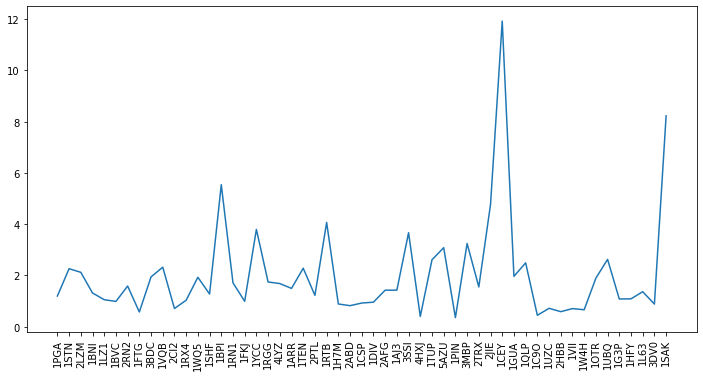

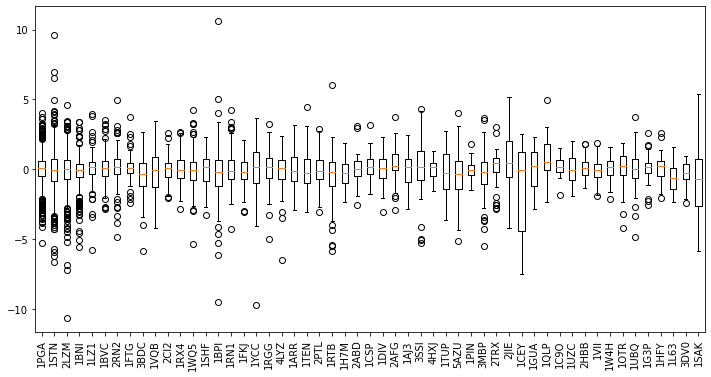

In [5]:
analyze('data/pred_DDG_Dataset_gpytorch.csv')

In [6]:
# analyze('data/pred_DDG_Dataset_lightGBM.csv')

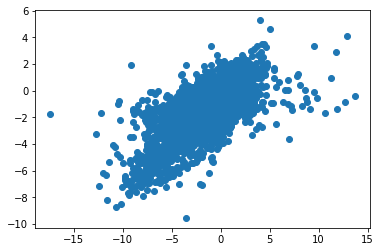

In [7]:
df = pd.read_csv('data/pred_DDG_Dataset_gpytorch_2.csv')
plt.scatter(df['ΔΔG'], df['pred_ΔΔG'])


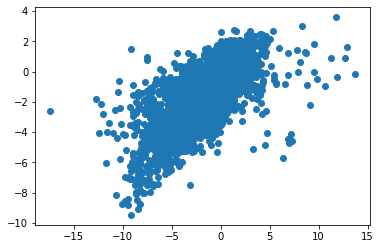

In [8]:
df = pd.read_csv('data/pred_DDG_Dataset_lightGBM.csv')
plt.scatter(df['ΔΔG'], df['pred_ΔΔG'])

In [12]:
df = pd.read_csv('data/pred_DDG_Dataset_gpytorch_2.csv')
df['diff'] = [abs(a - b) for a, b in zip(df['ΔΔG'], df['pred_ΔΔG'])]
counts = []
for index, row in df.iterrows():
    count = 0
    for i in range(31, 51):
        count += row.iloc[i]
        # print(row.iloc[i])
        
    counts.append(count)
    
df['count'] = counts
df = df.sort_values('diff', ascending=False)
tmp_df = pd.DataFrame({'PDB': df['PDB'], 
                       'Mutation': df['Mutation'], 
                       'pred': df['pred_ΔΔG'], 
                       'ΔΔG': df['ΔΔG'], 
                       'diff': df['diff'], 
                       'count': df['count']})
print(df['count'].mean())
tmp_df

26.916227299355594


,PDB,Mutation,pred,ΔΔG,diff,count
896,1CLW,R382S,-1.774659,-17.40,15.625341,32.0
29,1OH0,Y30S,-0.423101,13.70,14.123101,26.0
2781,1N0J,Y34F,-0.866845,12.70,13.566845,42.0
545,1OH0,Y14S,-1.373294,11.90,13.273294,29.0
4437,1QM4,R265H,-1.655543,10.61,12.265543,31.0
...,...,...,...,...,...,...
1992,2LZM,S44D,-0.110761,-0.11,0.000761,21.0
1953,1STN,E52G,-0.400681,-0.40,0.000681,22.0
589,2LZM,R119M,-0.099335,-0.10,0.000665,25.0
235,1BNI,D54N,-2.439353,-2.44,0.000647,30.0


In [10]:
df.iloc[:, 31:51]

,ASP,PHE,GLN,LYS,ILE,TYR,GLY,ASN,ARG,LEU,TRP,ALA,THR,VAL,HIS,CYS,GLU,MET,PRO,SER
896,2.0,4.0,1.0,0.0,4.0,1.0,4.0,2.0,1.0,5.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,2.0
29,3.0,1.0,0.0,0.0,4.0,3.0,1.0,0.0,3.0,2.0,0.0,4.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0
2781,2.0,1.0,1.0,2.0,1.0,0.0,3.0,6.0,0.0,4.0,3.0,3.0,1.0,2.0,8.0,0.0,1.0,0.0,0.0,4.0
545,1.0,2.0,2.0,0.0,2.0,1.0,2.0,0.0,2.0,3.0,0.0,2.0,0.0,3.0,0.0,1.0,2.0,4.0,2.0,0.0
4437,4.0,1.0,1.0,3.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0,1.0,2.0,2.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,1.0,0.0,0.0,2.0,2.0,0.0,2.0,3.0,1.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1953,3.0,0.0,0.0,4.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0,3.0,1.0
589,0.0,1.0,2.0,2.0,0.0,0.0,1.0,2.0,1.0,5.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0
235,1.0,1.0,1.0,1.0,4.0,3.0,2.0,1.0,3.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0
